# Packages

In [19]:
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import pyvis
import igraph as i
import matplotlib.pyplot as plt
from collections import Counter
import string
from tqdm import tqdm
import re
from cdlib import algorithms
from concurrent.futures import ThreadPoolExecutor
import powerlaw
import pickle

In [2]:
df_articles = pd.read_csv('_raw/articles_scraped.csv')

In [28]:
def prepare_df_connections(iterable):
    value_combinations = list(itertools.combinations(iterable, 2))
    df_connections = pd.DataFrame(value_combinations, columns=['entity_1','entity_2'])
    df_connections['weight'] = 0
    df_connections.reset_index(drop=True, inplace=True)

    return df_connections

In [29]:
def network_preparation(df_connections,dict_sizes): # df_connections is a dataframe of weighted edges
    elist = list(zip(df_connections['entity_1'],df_connections['entity_2'],df_connections['weight']))
    g = nx.Graph()
    g.add_weighted_edges_from([(el[0],el[1],el[2]) for el in elist if el[2]!=0])

    nt = pyvis.network.Network('1500px','1500px', bgcolor="#222222", font_color="white") #,select_menu=True,filter_menu=True)
    nt.barnes_hut()
    nt.from_nx(g) 
    nt.toggle_physics(True)

    for node in nt.nodes:
        node['font']['size'] = 100
        node['shape'] = 'circularImage'
        node['image'] = f"/Users/federico.bindi/Desktop/GitHub/organized-crime-articles/_aux/pictures/{node['id']}.png"
        node['size'] = dict_sizes[node['id']]

    return g,nt

# Individuals

## Preparation

In [5]:
df_individuals = pd.read_csv('_raw/individuals.csv')

In [6]:
dict_individuals = dict(zip(df_individuals.name,df_individuals.search_term))

In [7]:
dict_sizes = {}
for name in df_individuals.name.values:
    dict_sizes[name] = 0
    for article in df_articles.text.values:
        if dict_individuals[name] in article:
            dict_sizes[name] += 1

In [8]:
df_connections = prepare_df_connections(df_individuals.name.values)

Theoretically, we can analyse articles from 4 points of view:
1. Keyword extraction
2. Co-occurrence analysis (how many times two bosses' names appear close in an article)
3. Sentiment analysis on the articles

Points 2 and 3 are probably not useful: two bosses will appear closely in an article also if they are rival, and the articles are very likely to receive a negative sentiment classification anyway.

In [9]:
# Alliance Keywords with Regex Variations
alliance_keywords = [
    r"alliance", r"partner(s|ship|ing)?", r"cooperation", r"collaboration",
    r"joint venture", r"mutual support", r"united front", r"solidarity",
    r"work(ing)? together", r"coalition", r"team(ing)? up", r"combine(d)? forces",
    r"coordinated effort", r"combined operations", r"coordinated strategy",
    r"harmonious relationship", r"allied forces", r"mutual assistance"
]

# Rivalry Keywords with Regex Variations
rivalry_keywords = [
    r"rivalry", r"conflict", r"competition", r"feud", r"hostility", r"animosity",
    r"contention", r"dispute", r"antagonism", r"clash", r"enmity",
    r"competition for territory", r"power struggle", r"bitter rivalry",
    r"ongoing feud", r"turf war", r"opposing forces",
    r"confrontational relationship", r"longstanding dispute",
    r"battle for supremacy"
]

In [10]:
def count_words_in_text(keyword_list, text):
    
    counter = 0
    target_words = text.split()

    for keyword in keyword_list:
        matches = [1 if re.search(keyword,word) is not None else 0 for word in target_words]
        counter += sum(matches)
    
    return counter

In [11]:
def clean_text(text):
    # Create a translation table that maps punctuation characters to None
    translator = str.maketrans(string.punctuation, " " * len(string.punctuation))
    
    # Use the translate method to remove punctuation
    cleaned_text = text.lower().translate(translator)
    
    return cleaned_text

In [12]:
def detect_relationship(text, entity_1, entity_2):

    if entity_1 in text and entity_2 in text:

        alliance_score = count_words_in_text(alliance_keywords,clean_text(text))
        rivalry_score = count_words_in_text(rivalry_keywords,clean_text(text))

        if alliance_score > rivalry_score:
            return 1
        else:
            return 0
        
    else:
        return 0

In [13]:
for article in tqdm(df_articles.text.values):
    for row in range(len(df_connections)):

        entity_1 = dict_individuals[df_connections.loc[row,'entity_1']]
        entity_2 = dict_individuals[df_connections.loc[row,'entity_2']]

        df_connections.loc[row,'weight'] += detect_relationship(article, entity_1, entity_2)

df_connections.to_csv('_aux/Connections between individuals - alliances.csv')

100%|██████████| 10798/10798 [34:03<00:00,  5.28it/s] 


In [14]:
g, nt = network_preparation(df_connections,dict_sizes)
nt.show('_out/networks/individuals_alliances.html',notebook=False)

_out/networks/individuals_alliances.html


In [20]:
with open("_out/networks/individuals_alliances.pkl", "wb") as f:
    pickle.dump(g, f)

### Community detection (Louvain algorithm)

In [15]:
partition = algorithms.louvain(g, resolution=1., randomize=False)
print(partition.communities) # identified clustering

colors = ['#0000FF','#008000','#800080','#FF0000','#F0F8FF','#FF7F50','#B22222','#FF69B4','	#FFFACD']

for community,color_code in zip(partition.communities,colors):   
    for node in nt.nodes:
        if node['id'] in community:
            node['color'] = color_code

[['Genaro García Luna', 'Dámaso López Núñez', 'Edgardo Leyva Escandon', 'Joaquín Guzmán Loera', 'Ismael Zambada García', 'Hector Manuel Beltran Leyva', "Alejandro 'Omar' Treviño Morales", 'Jorge Eduardo Costilla Sánchez', 'Miguel Angel Treviño Morales', 'Nemesio Rubén Oseguera Cervantes', 'Reynerio Flores Lazo', 'José Natividad Luna Pereira', 'Juan Alberto Ortiz Lopez', 'Eliecer Erlinto Chamorro', 'Nicolás Rodríguez Bautista', 'Horst Walther Overdick', 'Vicente Carrillo Fuentes', 'Fausto Isidro Meza Flores', 'Marcos de Jesus Figueroa Garcia', 'Servando Gomez Martinez', 'Heriberto Lazcano', 'Moris Alexander Bercián Manchón', 'Vicente Carrillo Leyva', 'Fernando Sanchez Arellano', 'José Jesús Méndez Vargas', 'Nazario Moreno Gonzalez'], ['Ariel Máximo Cantero', 'Jobanis de Jesús Ávila Villadiego', 'Pablo Escobar', 'Diego Fernando Murillo Bejarano', 'Dairo Antonio Úsuga', 'Juan de Dios Úsuga', 'Daniel Barrera Barrera', 'Luis Agustin Caicedo Velandia', 'Martin Farfan Diaz Gonzalez', 'Victor 

### Preferential attachment mechanism

It would make sense to think that criminals prefer to form connections with other criminals that already have lots of connections (because they can offer more power and connections). This would be reflected in the degree distribution following a power law.

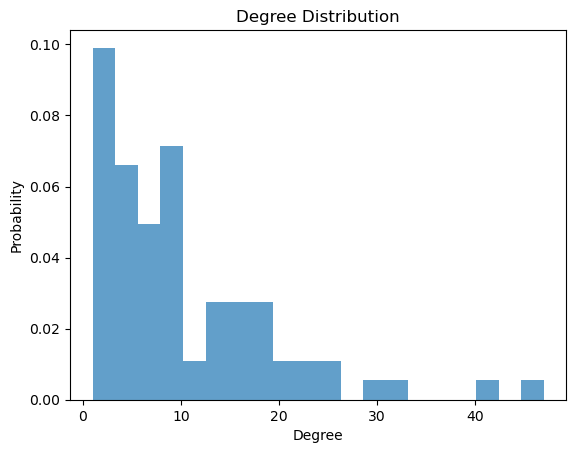

Calculating best minimal value for power law fit


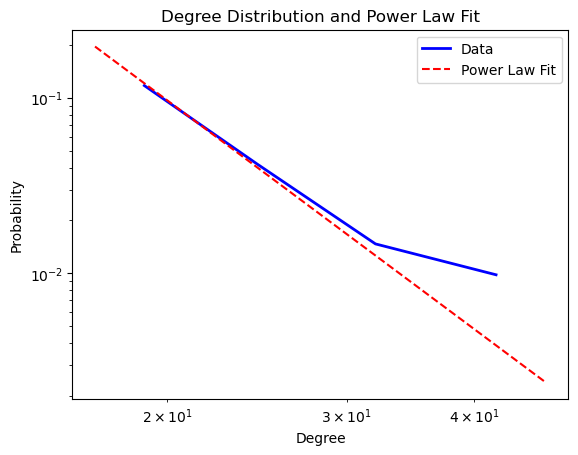

Power Law Fit Summary:
4.339187405285531
17.0
KS p-value: 0.07494013795368687


In [16]:
degree_sequence = [degree for node, degree in g.degree()]

plt.hist(degree_sequence, bins=20, density=True, alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution")
plt.show()

fit = powerlaw.Fit(degree_sequence)

fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=plt.gca())
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution and Power Law Fit")
plt.legend(['Data', 'Power Law Fit'])
plt.show()

print("Power Law Fit Summary:")
print(fit.power_law.alpha)
print(fit.power_law.xmin)
print("KS p-value:", fit.power_law.KS())
#print("Likelihood ratio p-value:", fit.power_law.distribution_compare('power_law', 'lognormal'))

### Validation

The first rows of the connections df are all corroborated by web search.

In [17]:
#df_connections = pd.read_csv('_aux/Connections between individuals - alliances.csv')
df_connections.sort_values('weight',ascending=False).head(30)

,ind_1,ind_2,weight
3811,Joaquín Guzmán Loera,Ismael Zambada García,41
3812,Joaquín Guzmán Loera,Hector Manuel Beltran Leyva,23
3913,Luis Enrique Calle Serna,Javier Antonio Calle Serna,22
3910,Diego Perez Henao,Luis Enrique Calle Serna,16
635,Pablo Escobar,Diego Fernando Murillo Bejarano,15
580,Ariel Máximo Cantero,Joaquín Guzmán Loera,14
3911,Diego Perez Henao,Javier Antonio Calle Serna,14
3825,Ismael Zambada García,Hector Manuel Beltran Leyva,14
2626,Nemesio Rubén Oseguera Cervantes,Joaquín Guzmán Loera,12
3720,Pedro Oliverio Guerrero Castillo,Daniel Barrera Barrera,12


# Groups

## Preparation

In [23]:
df_groups = pd.read_csv('_raw/groups.csv')

In [24]:
dict_groups = dict(zip(df_groups.name,df_groups.search_term))

In [25]:
dict_sizes2 = {}
for name in df_groups.name.values:
    dict_sizes2[name] = 0
    for article in df_articles.text.values:
        if dict_groups[name] in article:
            dict_sizes2[name] += 1

In [32]:
df_connections2 = prepare_df_connections(df_groups.name.values)

In [33]:
for article in tqdm(df_articles.text.values):
    for row in range(len(df_connections2)):

        entity_1 = dict_groups[df_connections2.loc[row,'entity_1']]
        entity_2 = dict_groups[df_connections2.loc[row,'entity_2']]

        df_connections2.loc[row,'weight'] += detect_relationship(article, entity_1, entity_2)

df_connections2.to_csv('_aux/Connections between groups - alliances.csv')

100%|██████████| 10798/10798 [26:47<00:00,  6.72it/s] 


In [34]:
g2, nt2 = network_preparation(df_connections2,dict_sizes2)
nt2.show('_out/networks/groups_alliances.html',notebook=False)

_out/networks/groups_alliances.html


In [35]:
with open("_out/networks/groups_alliances.pkl", "wb") as f:
    pickle.dump(g2, f)

## Community detection

In [36]:
partition2 = algorithms.louvain(g2, resolution=1., randomize=False)
print(partition2.communities) # identified clustering

colors = ['#0000FF','#008000','#800080','#FF0000','#F0F8FF','#FF7F50','#B22222','#FF69B4','	#FFFACD']

for community,color_code in zip(partition2.communities,colors):   
    for node in nt2.nodes:
        if node['id'] in community:
            node['color'] = color_code

[['First Capital Command', 'Bala na Cara', 'Family of the North', 'Cachiros', 'Barrio 18', 'Texis Cartel', 'MS13', 'Red Command', 'Perrones', 'Mendozas', 'Leones', 'Lorenzanas', 'Monos', 'Amigos dos Amigos', 'Pure Third Command', 'Atlantic Cartel', 'Perrones Cartel', 'CIACS'], ['Acacio Medina Front', 'Las Claritas Sindicato', 'The R Organization', 'Tren de Guayana', '10th Front', 'Border Security Colectivo', 'Second Marquetalia', 'Tren de Aragua', '1st Front', 'FARC', 'ELN', 'Valles', 'FBL', 'Shining Path', 'Bagdad', 'Calor Calor', 'Tren del Llano'], ['Jalisco Cartel New Generation', 'Cárteles Unidos', 'Knights Templar', 'Tijuana Cartel', 'Gulf Cartel', 'Familia Michoacana', 'Guerreros Unidos', 'Beltrán Leyva Organization', 'Juárez Cartel', 'Zetas', 'Fuerza Anti-Unión', 'Chapitos', 'Juarez Cartel', 'Barrio Azteca', 'La Unión Tepito', 'EPR'], ['Rastrojos', 'Pachenca', 'Gulf Clan', 'Autodefensas Unidas de Colombia', 'Oficina de Envigado', 'EPL', 'Cartel of the Suns', 'Norte del Valle Car

## Preferential attachment

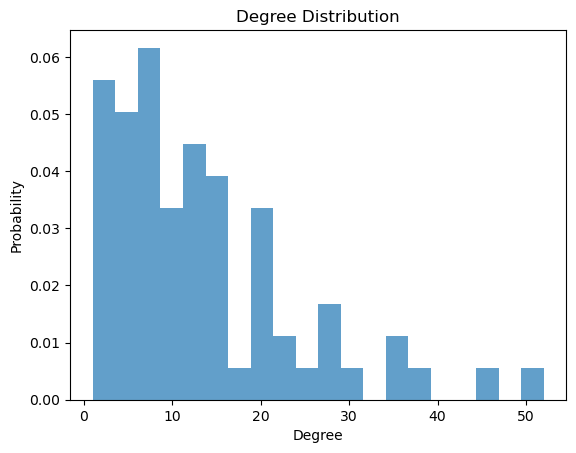

Calculating best minimal value for power law fit


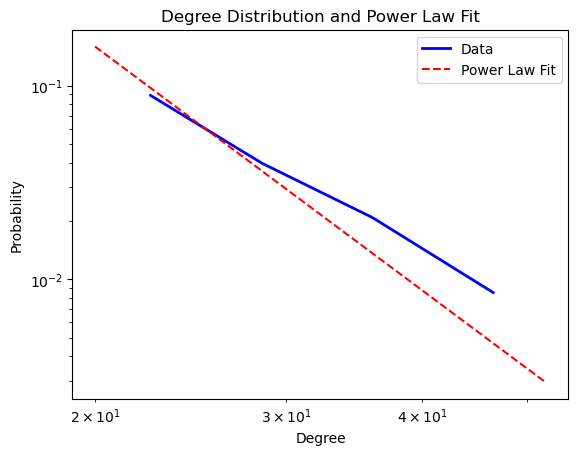

Power Law Fit Summary:
4.178036317554806
20.0
KS p-value: 0.1374244719795854


In [37]:
degree_sequence = [degree for node, degree in g2.degree()]

plt.hist(degree_sequence, bins=20, density=True, alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution")
plt.show()

fit = powerlaw.Fit(degree_sequence)

fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=plt.gca())
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution and Power Law Fit")
plt.legend(['Data', 'Power Law Fit'])
plt.show()

print("Power Law Fit Summary:")
print(fit.power_law.alpha)
print(fit.power_law.xmin)
print("KS p-value:", fit.power_law.KS())

## Validation

In [38]:
df_connections2.sort_values('weight',ascending=False).head(30)

,entity_1,entity_2,weight
1009,Sinaloa Cartel,Zetas,149
2386,FARC,ELN,103
2173,Gulf Cartel,Zetas,95
2290,Barrio 18,MS13,72
982,Sinaloa Cartel,Gulf Cartel,67
2385,FARC,Rastrojos,60
989,Sinaloa Cartel,FARC,53
2209,Familia Michoacana,Zetas,44
2415,Rastrojos,ELN,38
2499,Red Command,First Capital Command,35
